# Independent Research, INFO 4900
## Wally Chang wsc46

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import requests
import bs4
import textblob
import pathlib
from bs4 import BeautifulSoup
import time
import os
import glob
from datetime import datetime
from nltk import word_tokenize
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, PCA, TruncatedSVD
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
import random
import re
from sklearn.model_selection import train_test_split
import nltk
from sklearn.feature_selection import SelectKBest, mutual_info_regression, f_regression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.cluster import KMeans
import time


In [3]:
def clean_newsletters_MB(newsletters_df):

    # Define a function to filter out websites and replace numbers
    def filter_websites_and_numbers(text):
        # Filter out websites
        pattern_website = r'(http\:\/\/|https\:\/\/)?([a-z0-9][a-z0-9\-]*\.)+[a-z][a-z\-]*'
        text = re.sub(pattern_website, '', text)

        # Replace numbers with a 'num' tag (except 4-digit numbers)
        text = re.sub(r'\b\d{1,3}\b', 'num', text)
        return text

    # Apply the function to the 'paragraphs' column
    newsletters_df['paragraphs'] = newsletters_df['paragraphs'].apply(lambda x: [filter_websites_and_numbers(paragraph) for paragraph in x])

    # Define a function to remove text after the specified keyword in a single paragraph
    def remove_text_after_keyword(paragraph, keyword):
        for idx, text in enumerate(paragraph):
            if keyword in text:
                paragraph[idx] = text.split(keyword)[0]
        return paragraph

    filter_keywords = ['Share Morning Brew with your friends']

    # Apply the function to the 'paragraphs' column
    newsletters_df['paragraphs'] = newsletters_df['paragraphs'].apply(lambda x: remove_text_after_keyword(x, keyword) for keyword in filter_keywords)

    newsletters_df['title'] = newsletters_df['title'].str.replace(r'\s*\| Morning Brew', '', regex=True)

    filter_keywords = ['PRESENTED BY', 'TOGETHER WITH', 'SPONSORED BY']
    newsletters_df['paragraphs'] = newsletters_df['paragraphs'].apply(lambda x: '\n'.join([paragraph for paragraph in x if all(keyword not in paragraph for keyword in filter_keywords)]))

    # insert column label for the newsletter type
    newsletters_df.insert(0, 'newsletter', 'MB')

In [4]:
def clean_newsletters_NYT(newsletters_df):

     # Define a function to filter out websites and replace numbers
    def filter_websites_and_numbers(text):
        # Filter out websites
        pattern_website = r'(http\:\/\/|https\:\/\/)?([a-z0-9][a-z0-9\-]*\.)+[a-z][a-z\-]*'
        text = re.sub(pattern_website, '', text)

        # Replace numbers with a 'num' tag (except 4-digit numbers)
        text = re.sub(r'\b\d{1,3}\b', 'num', text)
        return text

    # Apply the function to the 'paragraphs' column
    newsletters_df['paragraphs'] = newsletters_df['paragraphs'].apply(lambda x: [filter_websites_and_numbers(paragraph) for paragraph in x])

    filter_keywords = ['Sign up here to get this newsletter in your inbox']

    # Define a function to remove text after the specified keyword in a single paragraph
    def remove_text_after_keyword(paragraph, keyword):
        for idx, text in enumerate(paragraph):
            if keyword in text:
                paragraph[idx] = text.split(keyword)[0]
        return paragraph

    # Apply the function to the 'paragraphs' column
    newsletters_df['paragraphs'] = newsletters_df['paragraphs'].apply(lambda x: remove_text_after_keyword(x, keyword) for keyword in filter_keywords)

    newsletters_df['title'] = newsletters_df['title'].str.replace(r'\s*\ - The New York Times', '', regex=True)

    filter_keywords = ['Advertisement', 'Newsletter','Supported by']
    newsletters_df['paragraphs'] = newsletters_df['paragraphs'].apply(lambda x: '\n'.join([paragraph for paragraph in x if all(keyword not in paragraph for keyword in filter_keywords)]))

    # insert column label for the newsletter type
    newsletters_df.insert(0, 'newsletter', 'NYT')

___________________________________________________________

# Reading and Processing Local MB Files

In [5]:
# local file read
def html_parser_from_local_html_text(text_file_path):

    all_data_local = []

    def date_style(tag):
        return tag.name == 'td' and tag.get('style') == 'font-family: Arial, Helvetica, sans-serif; font-size: 12px;color:#000000; '

    def bullet_points_style(tag):
        return tag.name == 'li' and tag.get('style') == 'line-height:22px;margin-bottom:10px'

    # Read the list of HTML content from the text file
    with open(text_file_path, 'r') as file:
        html_snippets = file.read().split('zulu')  # Assuming each snippet is separated by 'zulu'

    for html_content in html_snippets:
        soup = BeautifulSoup(html_content, 'html.parser')
        # Get title
        title = soup.title.text.strip()

        # Get dates
        dates_element = soup.find_all(date_style)
        date_texts = [date.text.strip() for date in dates_element]
        date_texts = [date.replace('[', '').replace(']', '') for date in date_texts]

        # Convert date strings to datetime objects
        date_objects = []
        for date_text in date_texts:
            date_obj = datetime.strptime(date_text, "%B %d, %Y")
            date_objects.append(date_obj)

        # Get paragraphs
        paragraphs = soup.find_all(['p', bullet_points_style])
        paragraph_texts = [p.text.strip() for p in paragraphs]

        # Get authors
        author_paragraphs = soup.find_all('p', style='line-height:22px;margin-top:0;margin-bottom:15px')

        # Get authors from the first occurrence in each paragraph
        authors = []
        for author_paragraph in author_paragraphs:
            paragraph_text = author_paragraph.get_text().strip()
            if paragraph_text.startswith("—"):
                em_tag = author_paragraph.find_next('em')
                if em_tag:
                    authors.extend([name.strip() for name in paragraph_text[1:].split(',')])
                    break
            else:
                em_tags = author_paragraph.find_all('em')
                for em_tag in em_tags:
                    em_text = em_tag.get_text().strip()
                    if em_text.startswith("—") or em_text.startswith("-"):
                        authors.extend([name.strip() for name in em_text[1:].split(',')])
                        break

        # Dictionary with data for each URL
        url_data = {
            'title': title,
            'date': date_obj.strftime('%Y-%m-%d'),
            'authors': authors,
            'paragraphs': paragraph_texts
        }

        # Append data to the list
        all_data_local.append(url_data)

    return all_data_local

# Example usage:
local_text_file_path = '/Users/wally/Library/CloudStorage/OneDrive-Personal/Documents/Cornell/1. Fourth Year/Independent Research/morning_brew_json.txt'
parsed_data = html_parser_from_local_html_text(local_text_file_path)

In [6]:
local_MB_df = pd.DataFrame(parsed_data)

In [7]:
# clean the newsletter dataframe
clean_newsletters_MB(local_MB_df)

# print the newsletter dataframe
local_MB_df

newsletter                title        date  \
0           MB            Duty free  2023-10-11   
1           MB        Spidey-Senses  2023-10-10   
2           MB  The outbreak of war  2023-10-09   
3           MB    Regicidal chatbot  2023-10-07   
4           MB       Greased Alaska  2023-10-06   
..         ...                  ...         ...   
300         MB            Sacrifice  2022-10-15   
301         MB    Netflix, with ads  2022-10-14   
302         MB               Pay up  2022-10-13   
303         MB       Dunkin' revolt  2022-10-12   
304         MB           Off camera  2022-10-11   

                                               authors  \
0    [Molly Liebergall, Matty Merritt, Sam Klebanov...   
1    [Sam Klebanov, Cassandra Cassidy, Molly Lieber...   
2                            [Neal Freyman, Dave Lozo]   
3    [Molly Liebergall, Sam Klebanov, Matty Merritt...   
4    [Matty Merritt, Molly Liebergall, Cassandra Ca...   
..                                                 ...   
300  [Neal Freyman, Matty Merritt, Abby Rubenstein,...   
301       [Neal Freyman, Max Knoblauch, Matty Merritt]   
302     [Neal Freyman, Abby Rubenstein, Matty Merritt]   
303     [Abby Rubenstein, Max Knoblauch, Neal Freyman]   
304  [Abby Rubenstein, Matty Merritt, Max Knoblauch...   

                                            paragraphs  
0    \nGood morning. In today’s edition:\nHow Hamas...  
1    \nGood morning. Today is num/num, the climax o...  
2    \nGood morning. Today is Columbus Day and Indi...  
3    \nGood morning. It’s the Saturday of a three-d...  
4    \nGood morning. For all the new managers in th...  
..                                                 ...  
300  \nGood morning on this beautiful fall weekend....  
301  \nGood morning. Tim Urban of Wait But Why pose...  
302  \nGood morning. There may not have been a drin...  
303  \nGood morning. Today, num/num/num, is one of ...  
304  \nGood morning. As part of Apple’s iconic “Thi...  

[305 rows x 5 columns]

In [8]:
#pd.options.display.max_rows = 999

___________________________________________________________

# Reading and Processing Local NYT Files

In [9]:
def NYT_html_parser_from_local_html_text(text_file_path):
    # Read the HTML content from the text file
    with open(text_file_path, 'r') as file:
        html_content = file.read()

    # Parse the HTML content
    soup = BeautifulSoup(html_content, 'html.parser')

    # Get title
    title = soup.title.text.strip()

    def has_data_testid(tag):
        return tag.has_attr('data-testid') and tag['data-testid'] == 'onsite-timestamp'

    def has_class_css3xqm5e(tag):
        return tag.has_attr('class') and 'css-3xqm5e' in tag['class']

    # Find the element based on the custom filter function
    date_element = soup.find(has_class_css3xqm5e)

    # Check if a date element was found
    if date_element:
        # Extract the date text
        date_text = date_element.find('time')['datetime'][:10]
    else:
        date_text = "Date not found"

    # Get author name
    author_element = soup.find('span', class_='css-1baulvz last-byline')
    if author_element and author_element.find('a'):
        author_name = author_element.find('a').text.strip()
    else:
        # If author name is not found in the first structure, check the secondary structure
        secondary_author_element = soup.find('span', class_='css-1baulvz last-byline', itemprop='name')
        author_name = secondary_author_element.text.strip() if secondary_author_element else "Author not found"

    # Get paragraphs
    paragraphs = soup.find_all('p')
    paragraph_texts = [p.text.strip() for p in paragraphs]

    # Create a dictionary with the data
    url_data = {
        'title': title,
        'date': date_text,
        'authors': author_name,
        'paragraphs': paragraph_texts
    }

    return url_data

In [10]:
NYT_folder_path = '/Users/wally/Library/CloudStorage/OneDrive-Personal/Documents/Cornell/1. Fourth Year/Independent Research/NYT'

file_extension = '*'

file_paths = glob.glob(os.path.join(NYT_folder_path, file_extension))

NYT_data = []

# Process each file and accumulate the data in all_data_local
for file_path in file_paths:
    data = NYT_html_parser_from_local_html_text(file_path)
    NYT_data.append(data)  # Append to the list with dictionaries

local_NYT_df = pd.DataFrame(NYT_data)

In [11]:
local_NYT_df = local_NYT_df.sort_values(by='date', ascending = False)
clean_newsletters_NYT(local_NYT_df)

In [12]:
local_NYT_df

newsletter                                             title        date  \
66         NYT                                  Hamas’s Hostages  2023-10-11   
299        NYT  The Nation’s Top-Performing Public School System  2023-10-10   
95         NYT        The Global Context of the Hamas-Israel War  2023-10-09   
279        NYT                       A Surprise Attack on Israel  2023-10-08   
46         NYT                             Meet the Plant People  2023-10-07   
..         ...                                               ...         ...   
81         NYT                                       Dressing Up  2022-10-15   
253        NYT                     Herschel Walker’s Polling Dip  2022-10-14   
1          NYT                       What Happened to Monkeypox?  2022-10-13   
314        NYT                Abortion Bans Weigh on Republicans  2022-10-12   
295        NYT                                  Russia’s Revenge  2022-10-11   

             authors                                         paragraphs  
66    Lauren Jackson  The scale of the hostage situation in the Gaza...  
299  David Leonhardt  Schools run by the Defense Department educate ...  
95   David Leonhardt  The Hamas attack is a sign of a new world orde...  
279  Steven Erlanger  Israel says it is at war with Gaza.\nBy Steven...  
46    Melissa Kirsch  For some, tending to our humble home gardens, ...  
..               ...                                                ...  
81    Melissa Kirsch  As the seasons change and more people return t...  
253        Nate Cohn  How the Senate race in Georgia is shaking out....  
1       German Lopez  Why cases suddenly began to decline.\nBy Germa...  
314       Lisa Lerer  Banning abortion is weighing on the party.\nBy...  
295     German Lopez  After weeks of setbacks on the battlefield, Ru...  

[365 rows x 5 columns]

___________________________________________________________

# Creating a Combined Dataset of NYT + MB

In [13]:
combined_datasets = pd.concat([local_NYT_df, local_MB_df], axis=0)

In [14]:
len(combined_datasets)

670

In [15]:
# Shuffling rows within the dataset to mitigate any effects of concatenation
combined_datasets = combined_datasets.sample(frac=1, random_state=42).reset_index(drop=True)
combined_datasets.head(12)

newsletter                                              title        date  \
0         NYT                      Herschel Walker’s Polling Dip  2022-10-14   
1         NYT                                It’s Coronation Day  2023-05-06   
2          MB                                Abercrombie is back  2023-05-25   
3          MB                                        They got 50  2022-11-14   
4         NYT                                  Brazil and Jan. 6  2023-01-10   
5         NYT                        What Happened to Monkeypox?  2022-10-13   
6         NYT                The End of a Presidential Launchpad  2022-12-06   
7         NYT                              History in the Rubble  2023-03-26   
8          MB                                  Breaking the seal  2023-04-05   
9         NYT                              Compounding Disasters  2023-07-13   
10        NYT                    Welcome to Barbenheimer Weekend  2023-07-22   
11        NYT  Debt Ceiling Fight Is Putting U.S. Economy at ...  2023-01-20   

                                              authors  \
0                                           Nate Cohn   
1                                      Melissa Kirsch   
2   [Molly Liebergall, Matty Merritt, Cassandra Ca...   
3                                      [Neal Freyman]   
4                                        German Lopez   
5                                        German Lopez   
6                                         Peter Baker   
7                                           Ashley Wu   
8         [Sam Klebanov, Matty Merritt, Neal Freyman]   
9                                        German Lopez   
10                                     Melissa Kirsch   
11                                       German Lopez   

                                           paragraphs  
0   How the Senate race in Georgia is shaking out....  
1   Come for the crown jewels and gold stagecoach;...  
2   \nGood morning. If you thought you were gettin...  
3   \nGood morning. If you’re looking for a distra...  
4   How Brazil’s riots compare to the Jan. num att...  
5   Why cases suddenly began to decline.\nBy Germa...  
6   Democrats stripped Iowa of its first-in-the-na...  
7   Documenting the damage of last month’s earthqu...  
8   \nGood morning and Happy Passover to all those...  
9   America’s compounding natural disasters show t...  
10  You have little choice but to surrender to the...  
11  A political fight is again putting the economy...

In [16]:
# Convert the 'date' column to datetime format
combined_datasets['date'] = pd.to_datetime(combined_datasets['date'])

# Create a new column 'month' with the month number
combined_datasets['month'] = combined_datasets['date'].apply(lambda x: x.month)

# Display the updated DataFrame
combined_datasets

newsletter                                              title       date  \
0          NYT                      Herschel Walker’s Polling Dip 2022-10-14   
1          NYT                                It’s Coronation Day 2023-05-06   
2           MB                                Abercrombie is back 2023-05-25   
3           MB                                        They got 50 2022-11-14   
4          NYT                                  Brazil and Jan. 6 2023-01-10   
..         ...                                                ...        ...   
665        NYT  A Closer Look at the Registered Voters Who Don... 2023-08-01   
666        NYT                             115 Degrees Fahrenheit 2023-06-27   
667        NYT                                 Israel Moves Right 2023-01-15   
668         MB                                  Ice cream so good 2023-07-20   
669        NYT                                   A Mini Challenge 2023-07-01   

                                               authors  \
0                                            Nate Cohn   
1                                       Melissa Kirsch   
2    [Molly Liebergall, Matty Merritt, Cassandra Ca...   
3                                       [Neal Freyman]   
4                                         German Lopez   
..                                                 ...   
665                                    David Leonhardt   
666                                       German Lopez   
667                               Ian Prasad Philbrick   
668  [Cassandra Cassidy, Matty Merritt, Molly Liebe...   
669                                      Joel Fagliano   

                                            paragraphs  month  
0    How the Senate race in Georgia is shaking out....     10  
1    Come for the crown jewels and gold stagecoach;...      5  
2    \nGood morning. If you thought you were gettin...      5  
3    \nGood morning. If you’re looking for a distra...     11  
4    How Brazil’s riots compare to the Jan. num att...      1  
..                                                 ...    ...  
665  Looking more closely at the registered voters ...      8  
666  Summer technically just began, and parts of th...      6  
667  Israel’s new right-wing government is moving q...      1  
668  \nGood morning. Our inbox was a house divided ...      7  
669  A special edition of a Times puzzle designed f...      7  

[670 rows x 6 columns]

___________________________________________________________

# Basic Processing and Comparisons

In [17]:
# Number of words
def word_stats(data, stopwords=None, n=20):
    words_in_text = len(data)
    word_stats_counter = Counter()
    for token in data:
        word_stats_counter[token] += 1
    top_20_words = word_stats_counter.most_common(n)
    return words_in_text, top_20_words

In [18]:
def total_tokens_and_top_20(text):
    newsletter_stats = {}

    # Iterate over newsletters
    for i, newsletter in enumerate(text):
        MB_tokens = word_tokenize(newsletter)

        # Get word statistics
        tokens_in_text, top_20_tokens = word_stats(MB_tokens)

        # Append the statistics to the dictionary with the newsletter index as the key
        newsletter_stats[i] = {'tokens_in_text': tokens_in_text, 'top_20_words': top_20_tokens}

    # Return the statistics from the dictionary
    return newsletter_stats

In [19]:
def calculate_token_statistics(tokens):
    # Calculate the mean
    median_words_in_text = np.median(tokens)

    # Calculate the 25th percentile
    percentile_25 = np.percentile(tokens, 25)

    # Calculate the 75th percentile
    percentile_75 = np.percentile(tokens, 75)

    return {
        "Median tokens in text: ": median_words_in_text,
        "25th Percentile": percentile_25,
        "75th Percentile": percentile_75
    }

## Morning Brew

In [20]:
# Defining Morning Brew subset of combined_dataset
MB = combined_datasets[combined_datasets['newsletter'] == 'MB']

In [21]:
# Number of MB newsletters
print('Newsletters in MB Corpus: ', len(MB))

# Get the oldest date (first row)
newest_date = MB['date'].iloc[0]

# Get the newest date (last row)
oldest_date = MB['date'].iloc[-1]

print('Oldest Date:', oldest_date)
print('Newest Date:', newest_date)

Newsletters in MB Corpus:  305
Oldest Date: 2023-07-20 00:00:00
Newest Date: 2023-05-25 00:00:00


In [22]:
# Get stats from MB paragraphs
newsletter_stats_MB = total_tokens_and_top_20(MB['paragraphs'])

In [23]:
# Collect total tokens by newsletter
MB_total_tokens_by_newsletter = []
for x in range(len(newsletter_stats_MB)):
    MB_total_tokens_by_newsletter.append(newsletter_stats_MB[x]['tokens_in_text'])

In [24]:
calculate_token_statistics(MB_total_tokens_by_newsletter)

{'Median tokens in text: ': 2549.0,
 '25th Percentile': 2471.0,
 '75th Percentile': 2653.0}

In [25]:
# Split documents into paragraphs
paragraphs = [text.split('\n') for text in MB['paragraphs']]

# Flatten the list of paragraphs and remove any empty paragraphs
paragraphs = [paragraph.strip() for text in paragraphs for paragraph in text if paragraph.strip()]

In [26]:
# Create vectorizer
vectorizer = CountVectorizer( # Token counts, not normalized (sklearn normalizes later)
    input = 'content',
    encoding = 'utf-8',
    strip_accents = 'unicode',
    #stop_words='english', # uncomment to remove fixed stops from input
    lowercase = True,
    min_df = 0.001, # Remember that we've chunked by paragraph
    max_df = 0.25,    # Ditto
    ngram_range=(1,2)
)

X = vectorizer.fit_transform(paragraphs)
print("Feature matrix shape:", X.shape)
print("Total vectorized tokens in the corpus:", X.sum())

Feature matrix shape: (31736, 3762)
Total vectorized tokens in the corpus: 576956


In [27]:
lda = LatentDirichletAllocation(
    n_components=50, # Number of topics to find
    n_jobs=-1,       # Use all CPU cores
    verbose=0,       # Print progress
    max_iter=30,     # Might want more in production work
    evaluate_every=0 # Set >=1 to test for convergence (slow, but can stop iteration)
)

lda.fit(X)

LatentDirichletAllocation(evaluate_every=0, max_iter=30, n_components=50,
                          n_jobs=-1)

In [28]:
def print_top_words(model, feature_names, n_top_words, hide_stops=False):
    if hide_stops:
        from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

    for topic_idx, topic in enumerate(model.components_):
        message = f"Topic {topic_idx: >2}: "
        top_words_idx = topic.argsort()
        if not hide_stops:
            top_words = [feature_names[i]
                         for i in top_words_idx[:-n_top_words - 1:-1]]
        else:
            top_words = []
            i = 1
            while len(top_words) < n_top_words:
                if feature_names[top_words_idx[-i]] not in ENGLISH_STOP_WORDS:
                    top_words.append(feature_names[top_words_idx[-i]])
                i += 1
        message += " ".join(top_words)
        print(message)
    print()

#### MB Only Topic Model

In [29]:
print_top_words(lda, vectorizer.get_feature_names_out(), n_top_words=10, hide_stops=False)

Topic  0: musk twitter after that with was on who for he
Topic  1: analytics analytics and that pay trying trying to for from department agreed
Topic  2: sign up sign up email was this you to you was this you sign
Topic  3: num num bps num bps on num march num aka remaining the number is num good
Topic  4: game on for team with strike is in the sports of the
Topic  5: on week this her this week she last friday weekend night
Topic  6: every valley quick silicon valley silicon the week the business updates day every day
Topic  7: we link you friends and more share saying more free stuff
Topic  8: than more according according to more than num of from for that than num
Topic  9: day good morning of the good morning is word the day for thanks
Topic 10: you if re if you brands you re they they re we we re
Topic 11: help it time your for to help that help you with brew
Topic 12: be will to be it next will be but is that expected
Topic 13: is at no at the end by of the which so as
Topic 14: m

## New York Times

In [30]:
# Defining NYT subset of combined_dataset
NYT = combined_datasets[combined_datasets['newsletter'] == 'NYT']

In [31]:
# Number of NYT newsletters
print('Newsletters in NYT Corpus: ', len(NYT))

# Get the oldest date (first row)
newest_date = NYT['date'].iloc[0]

# Get the newest date (last row)
oldest_date = NYT['date'].iloc[-1]

print('Oldest Date:', oldest_date)
print('Newest Date:', newest_date)

Newsletters in NYT Corpus:  365
Oldest Date: 2023-07-01 00:00:00
Newest Date: 2022-10-14 00:00:00


In [32]:
# Get stats from NYT paragraphs
newsletter_stats_NYT = total_tokens_and_top_20(NYT['paragraphs'])

In [33]:
# Collect total tokens by newsletter
NYT_total_tokens_by_newsletter = []
for x in range(len(newsletter_stats_NYT)):
    NYT_total_tokens_by_newsletter.append(newsletter_stats_NYT[x]['tokens_in_text'])

In [34]:
calculate_token_statistics(NYT_total_tokens_by_newsletter)

{'Median tokens in text: ': 1956.0,
 '25th Percentile': 1847.0,
 '75th Percentile': 2054.0}

In [35]:
# Split documents into paragraphs
paragraphs = [text.split('\n') for text in NYT['paragraphs']]

# Flatten the list of paragraphs and remove any empty paragraphs
paragraphs = [paragraph.strip() for text in paragraphs for paragraph in text if paragraph.strip()]

In [36]:
X = vectorizer.fit_transform(paragraphs)
print("Feature matrix shape:", X.shape)
print("Total vectorized tokens in the corpus:", X.sum())

Feature matrix shape: (26504, 4068)
Total vectorized tokens in the corpus: 514408


In [37]:
lda.fit(X)

LatentDirichletAllocation(evaluate_every=0, max_iter=30, n_components=50,
                          n_jobs=-1)

#### NYT Only Topic Model

In [38]:
print_top_words(lda, vectorizer.get_feature_names_out(), n_top_words=10, hide_stops=False)

Topic  0: one women on one of men did of the with carolina talk
Topic  1: on times on the writes the times by are here is here are
Topic  2: new new york york city the new in new by times by the york city
Topic  3: white washington story today newsletter post 2022 reports white house at
Topic  4: is that not but it change that the of the one climate
Topic  5: world country the world the country by david cup by david world cup leonhardt
Topic  6: state an the state documents texas from for after officials of the
Topic  7: lauren jackson morning the morning ian lauren jackson reach team prasad ian prasad
Topic  8: week see this this week take news quiz well to see how
Topic  9: ukraine russia war russian is putin for the war ukrainian military
Topic 10: republicans house party republican democrats voters for democratic senate the house
Topic 11: num num num old million year num million num year year old to num the num
Topic 12: right that has students political of the during as pandemic 

#### Visualizing the 500 Most Frequently Occurring Token Unigrams Between MB and NYT, Using Truncated SVD

In [39]:
# Vectorizer to get token unigram counts
vectorizer = TfidfVectorizer(max_features=700, stop_words='english')
X = vectorizer.fit_transform(combined_datasets['paragraphs'])

# Convert the matrix to DataFrame
features = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())

# Set features and labels
labels = combined_datasets['newsletter']
features = features  # No length normalization

# Display the shapes of features and labels
print('Features Shape:', features.shape, 'Labels Shape:', labels.shape)

Features Shape: (670, 700) Labels Shape: (670,)


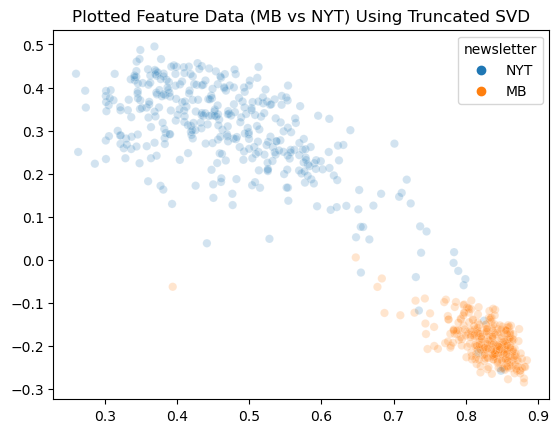

In [40]:
# Plot the feature data, default: 2 dimensional truncated SVD
features_reduced = TruncatedSVD().fit_transform(features)
sns.scatterplot(x=features_reduced[:,0], y=features_reduced[:,1], hue=labels, alpha=0.2)
plt.title('Plotted Feature Data (MB vs NYT) Using Truncated SVD')
plt.show()

_________________________________

# Unsupervised Cluster Analysis

/Users/wally/anaconda3/envs/INFO4900/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/wally/anaconda3/envs/INFO4900/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Plotting the Elbow curve took:3.9s 


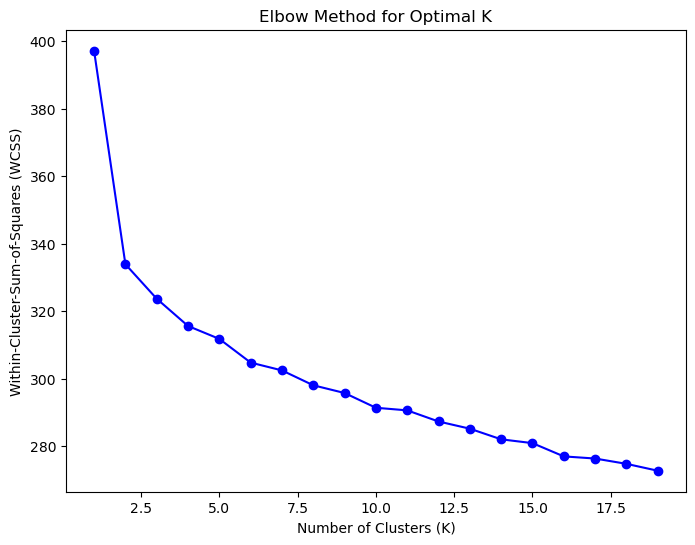

In [41]:
# Using the elbow method to find the optimal number of clusters
# Referenced: https://www.analyticsvidhya.com/blog/2021/01/in-depth-intuition-of-k-means-clustering-algorithm-in-machine-learning/

wcss = [] 
t0 = time.time()
for i in range(1, 20): 
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(X) 
    wcss.append(kmeans.inertia_)
t1 = time.time()
    
print("Plotting the Elbow curve took:{:.1f}s ".format(t1-t0))

# Plotting the Elbow Curve
plt.figure(figsize=(8, 6))
plt.plot(range(1, 20), wcss, marker='o', linestyle='-', color='b')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Within-Cluster-Sum-of-Squares (WCSS)')
plt.show()

In [42]:
y_pred = KMeans(n_clusters=3, n_init='auto').fit_predict(X)

In [43]:
# Plotting function
def plot_compare(X, labels, title, alpha=0.2):
    '''
    Takes an array of object data, a list of cluster labels, a title string, and an optional alpha value.
    Reduces dimensions to 2 if necessary and plots the clustering with and without coloring by label.
    Returns nothing.
    '''
    if X.shape[1] > 2:
        svd = TruncatedSVD(n_components=3)
        X_2d = svd.fit_transform(X)
    else:
        X_2d = X

    # initialize figsize in prompt
    plt.figure(figsize=(12, 6))

    # left subplot, alpha value in function cell
    plt.subplot(121)
    plt.scatter(X_2d[:, 0], X_2d[:, 1], alpha=alpha)
    plt.title("Dimension-Reduced Unclustered Data")

    # right subplot, same coordinate data and supplied cluster labels, alpha value in function cell
    plt.subplot(122)
    plt.scatter(X_2d[:, 0], X_2d[:, 1], c=labels, alpha=alpha)
    plt.title("Data with Clustering")

    # Set the common title for the entire figure
    plt.title(title)

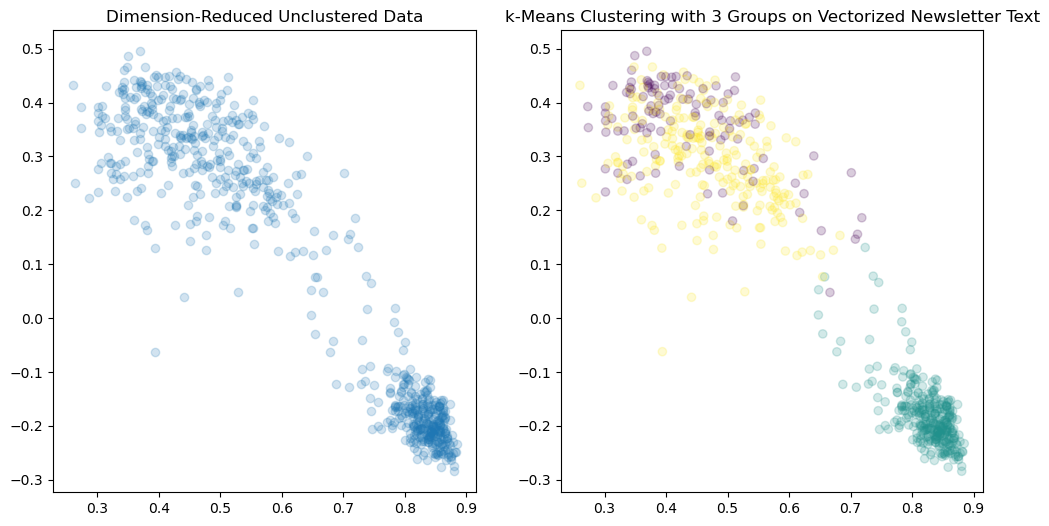

In [44]:
# plot resulting clustering
plot_compare(X, y_pred, 'k-Means Clustering with 3 Groups on Vectorized Newsletter Text')

______________________________

# Topic Based Models Using Default Paragraphs as Features

In [45]:
vectorizer = TfidfVectorizer()

In [46]:
paragraphs = []
newsletter_types = []
dates = []

combined_datasets['date'] = combined_datasets['date'].dt.strftime('%Y-%m-%d')

for text, newsletter_type, date in zip(combined_datasets['paragraphs'], combined_datasets['newsletter'], combined_datasets['date']):
    # Split the text into paragraphs using '\n'
    text_paragraphs = text.split('\n')

    paragraphs.extend(text_paragraphs)

    newsletter_types.extend([newsletter_type] * len(text_paragraphs))

    dates.extend([date] * len(text_paragraphs))

for i in range(len(newsletter_types)):
    if newsletter_types[i] == 'NYT':
        newsletter_types[i] = 1
    else:
        newsletter_types[i] = 0

In [47]:
X = vectorizer.fit_transform(paragraphs)
print("Feature matrix shape:", X.shape)
print("Total vectorized words in the corpus:", X.sum())
print("Average vectorized paragraph length:", int(X.sum()/X.shape[0]), "tokens")

Feature matrix shape: (59839, 38726)
Total vectorized words in the corpus: 203596.4424350642
Average vectorized paragraph length: 3 tokens


In [48]:
# fitting combined dataset
lda.fit(X)

LatentDirichletAllocation(evaluate_every=0, max_iter=30, n_components=50,
                          n_jobs=-1)

#### Top words from 50 Topics with full Token Unigram Set as Features

In [49]:
print_top_words(lda, vectorizer.get_feature_names_out(), n_top_words=10, hide_stops=False)

Topic  0: podcasts interested in the leonhardt david times podcast magazine pulitzer
Topic  1: search the num in cup game women world and tournament
Topic  2: books the 2019 picks prince book santos editors george novel
Topic  3: july career courses accelerate our your with gulf gifts carter
Topic  4: russia ukraine putin russian war ukrainian vladimir sea black zelensky
Topic  5: leadership reserved rights all jan 1960 oil nichols tucker counsel
Topic  6: brands jigsaw tenn oppenheimer liberal iran knee joint barbie monogram
Topic  7: missing odd voters three registered one spot faker real charles
Topic  8: the bank interest rates is of rate num banks inflation
Topic  9: link we you 2020 stuff share give saying friends ll
Topic 10: died the lives lived at she num her was of
Topic 11: you to the your it and for of we can
Topic 12: word day of the excel 1990 2005 mug submit coffee
Topic 13: thanks spending part times tomorrow your see with morning for
Topic 14: valley silicon updates st

In [50]:
doc_topic_matrix = lda.transform(X)
print("Doc-topic matrix shape:", doc_topic_matrix.shape)

# Fit and predict using topics
X_topics = StandardScaler().fit_transform(doc_topic_matrix)

Doc-topic matrix shape: (59839, 50)


In [51]:
X = vectorizer.fit_transform(paragraphs)
lda.fit(X)

LatentDirichletAllocation(evaluate_every=0, max_iter=30, n_components=50,
                          n_jobs=-1)

In [52]:
X

<59839x38726 sparse matrix of type '<class 'numpy.float64'>'
	with 1070329 stored elements in Compressed Sparse Row format>

### Baseline Logistic Regression Classification of Newsletter using Topic Features

In [53]:
predictor = LogisticRegression()
predictor.fit(X_topics, newsletter_types)
y_pred = predictor.predict(X_topics)

# Cross-validation to evaluate the model
cv_accuracy = np.mean(cross_val_score(LogisticRegression(), X_topics, newsletter_types, scoring='accuracy', cv=10))
print("Mean cross-validated accuracy:", round(cv_accuracy, 3))

Mean cross-validated accuracy: 0.697


### Baseline Linear Regression Prediction of Publication Date using Topic Features

In [54]:
# Convert date types into an integer representation
reference_date = datetime(2022, 10, 11)
date_integers = [(datetime.strptime(date_str, "%Y-%m-%d") - reference_date).days for date_str in dates]

In [55]:
predictor = LinearRegression()
predictor.fit(X_topics, date_integers)
y_pred = predictor.predict(X_topics)

# Cross-validation to evaluate the model
print("Mean cross-validated R^2 (topics):", round(np.mean(cross_val_score(LinearRegression(), X_topics, date_integers, scoring='r2', cv=10)),3))

Mean cross-validated R^2 (topics): -0.019


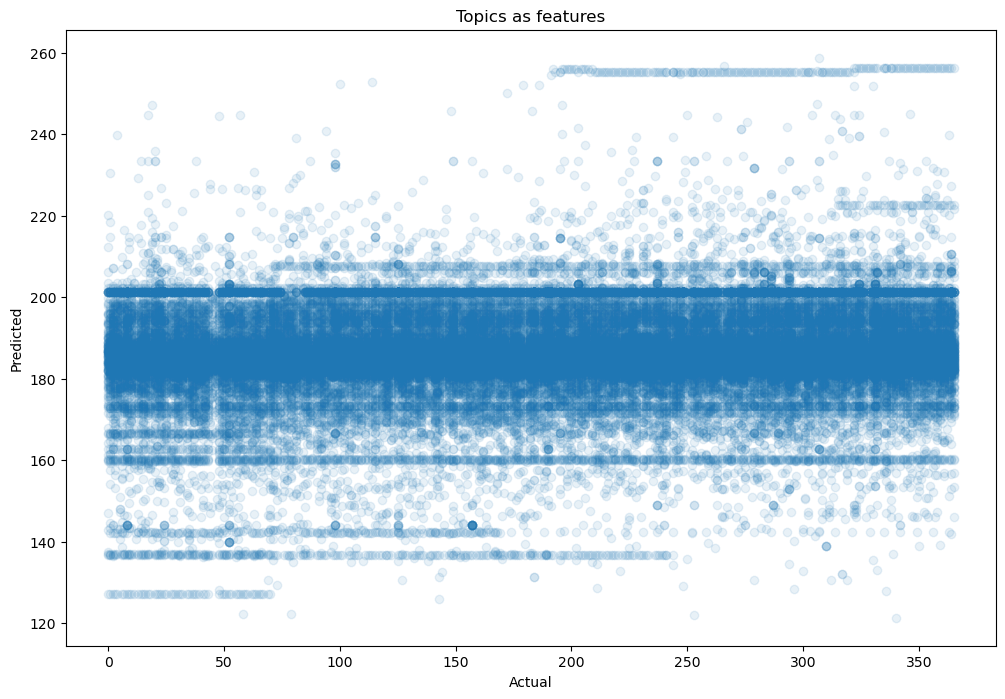

In [56]:
# Plot
fig,ax = plt.subplots(figsize=(12,8))
sns.regplot(x=date_integers, y=y_pred, scatter_kws={'alpha':0.1})
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Topics as features")
plt.show()

### Time Series Showing Probability of Topics Over Integer Time Axis

/Users/wally/anaconda3/envs/INFO4900/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/wally/anaconda3/envs/INFO4900/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


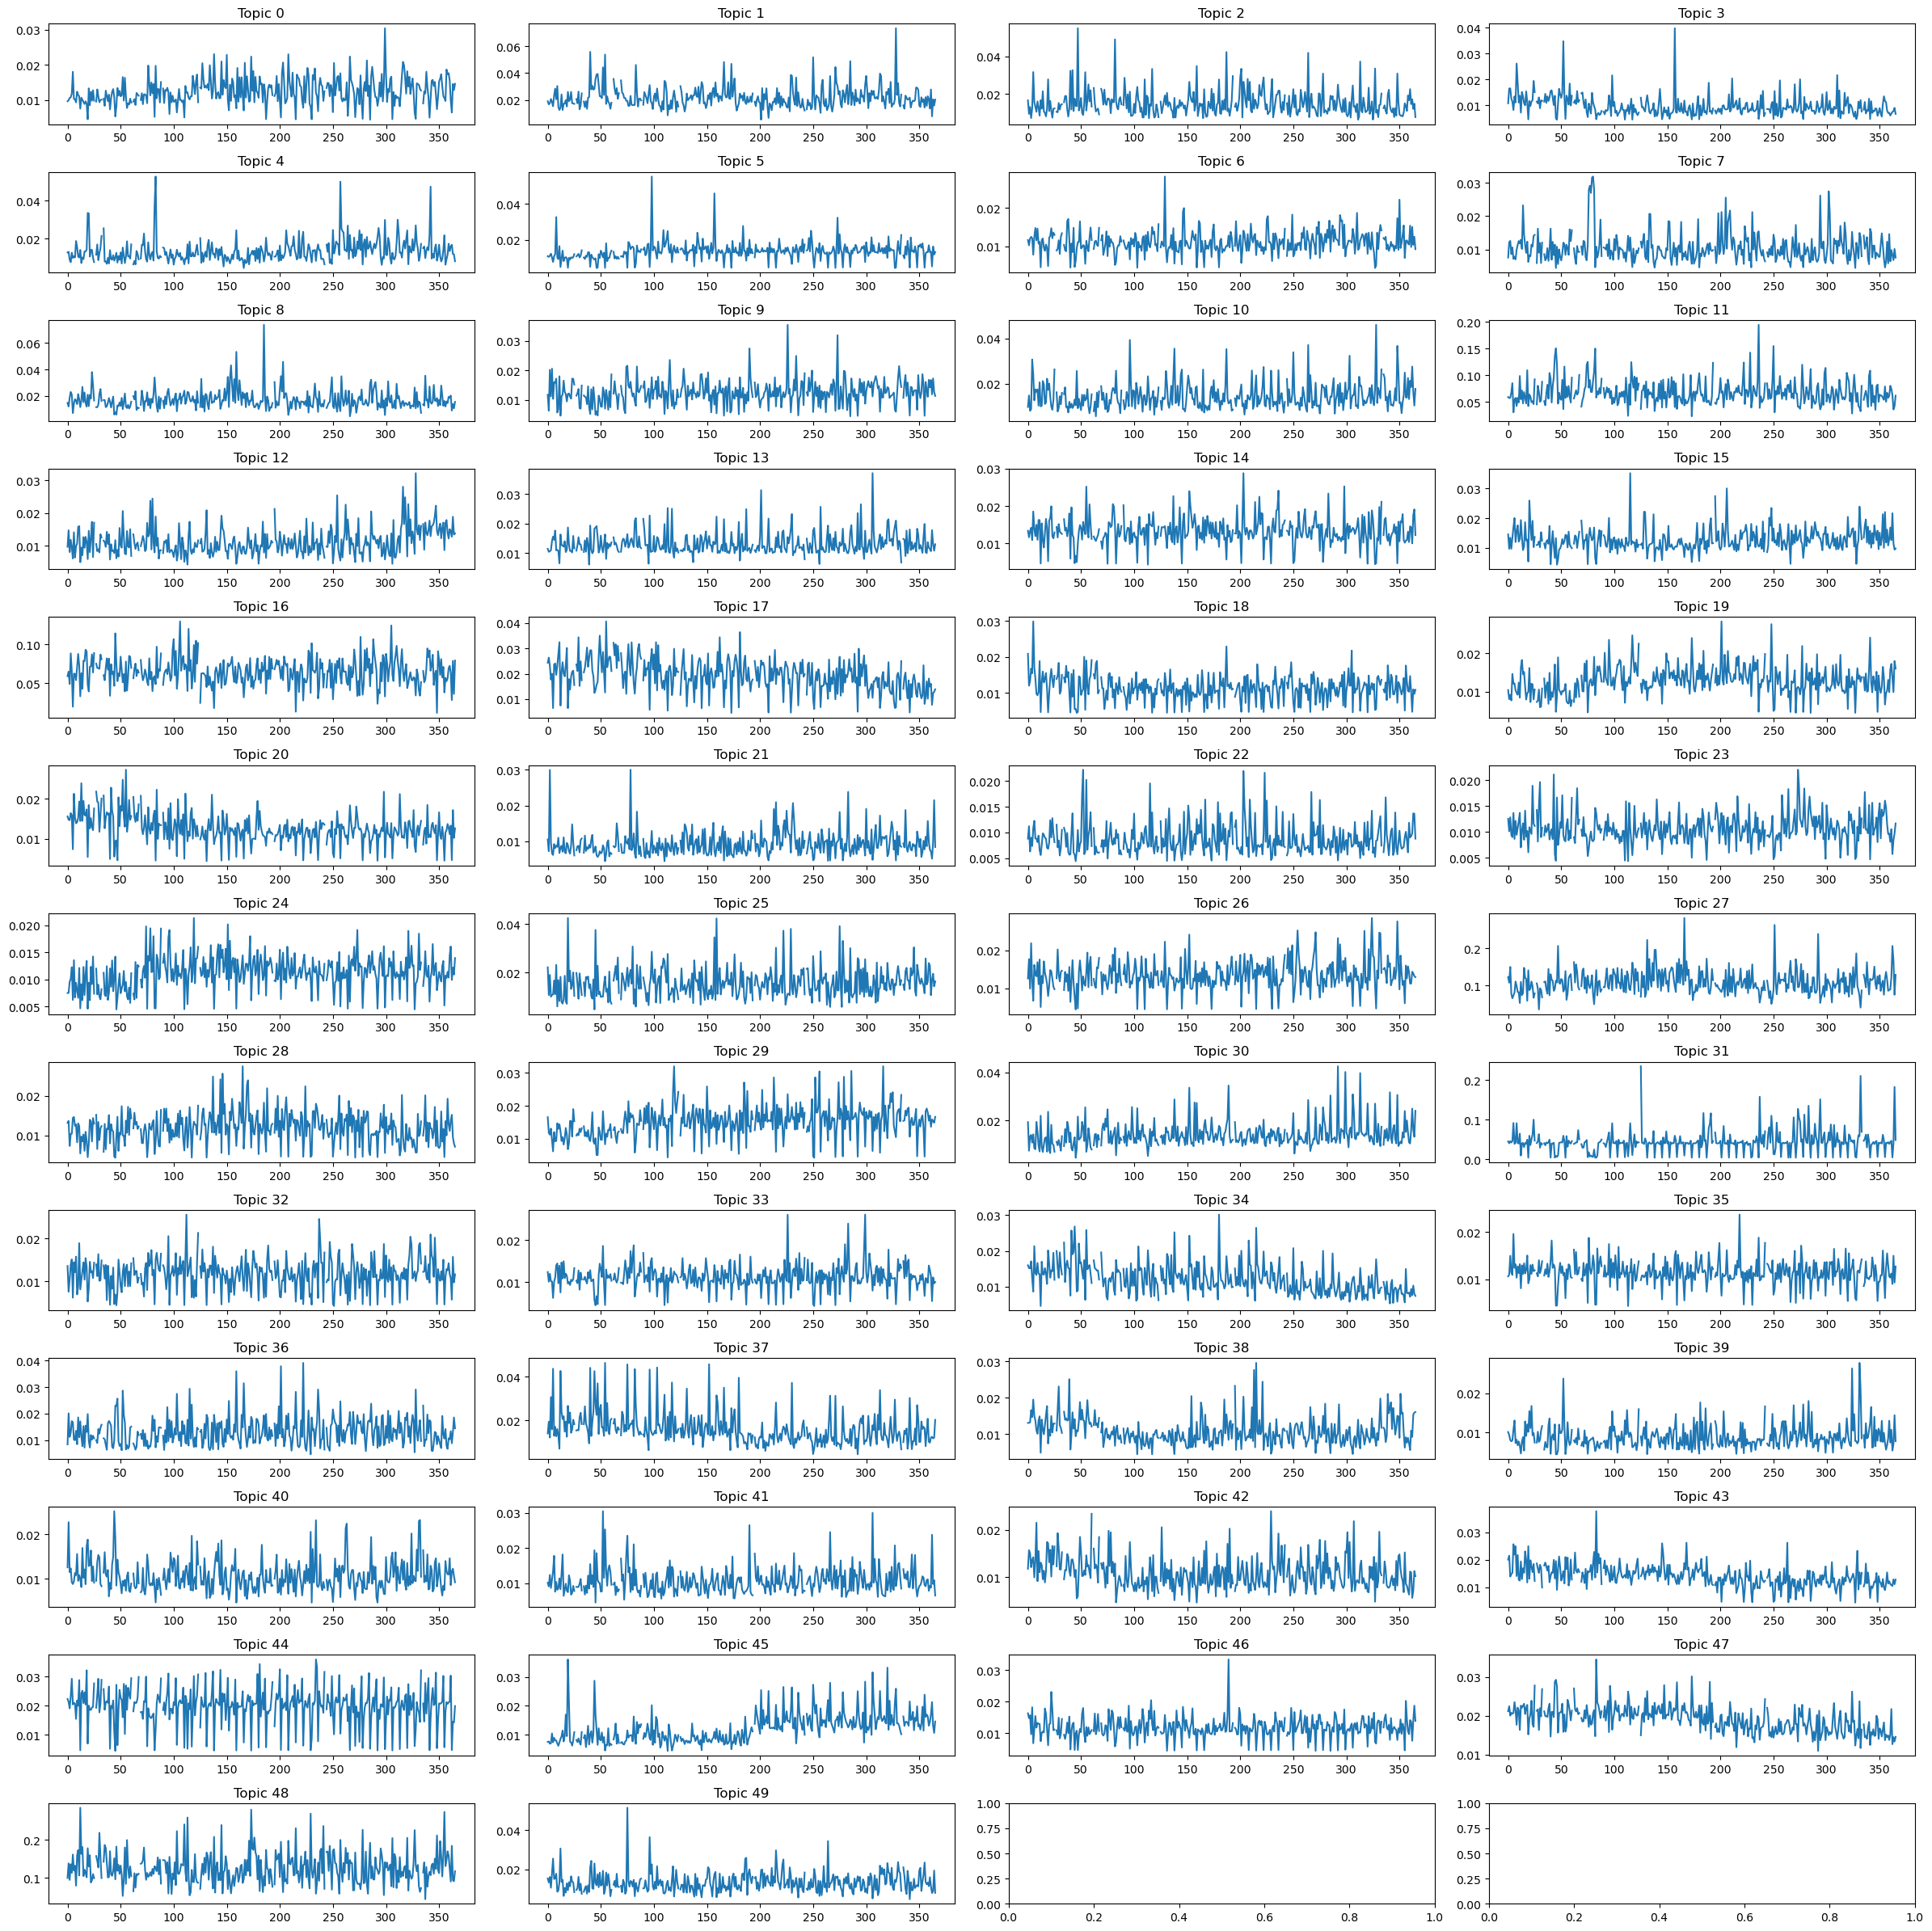

In [57]:
# Time series
n_cols = 4
n_topics = doc_topic_matrix.shape[1]
n_rows = n_topics/n_cols
if n_rows%1!=0:
    n_rows += 1
n_rows = int(n_rows)

fig, axs = plt.subplots(n_rows, n_cols, figsize=(24,24))
axs = axs.ravel()

valid_dates = list(range(366))
for topic in range(n_topics):
    topic_data = doc_topic_matrix[:,topic]
    topic_means = []
    for date in valid_dates:
        mask = np.equal(date_integers, date)
        topic_mean = np.mean(topic_data[mask])
        topic_means.append(topic_mean)
    axs[topic].plot(valid_dates, topic_means)
    axs[topic].set_title(f'Topic {topic}')
plt.tight_layout()
plt.show()

#### Show the coefficients from each topic

In [58]:
coefficients = predictor.coef_

# Display coefficients for each topic
for topic in range(n_topics):
    print(f'Topic {topic} Coefficients: {coefficients[topic]}')

Topic 0 Coefficients: 12743680345867.21
Topic 1 Coefficients: 15516534126258.188
Topic 2 Coefficients: 10977893591172.16
Topic 3 Coefficients: 8127914432640.494
Topic 4 Coefficients: 10082464613522.736
Topic 5 Coefficients: 13124223930228.865
Topic 6 Coefficients: 9334769010172.982
Topic 7 Coefficients: 8526934077105.492
Topic 8 Coefficients: 12112300929215.656
Topic 9 Coefficients: 12865066547443.3
Topic 10 Coefficients: 10697300848261.55
Topic 11 Coefficients: 31671510553967.934
Topic 12 Coefficients: 8785347175405.363
Topic 13 Coefficients: 13353930285479.701
Topic 14 Coefficients: 13569877831207.227
Topic 15 Coefficients: 11464829968215.22
Topic 16 Coefficients: 32410771709070.348
Topic 17 Coefficients: 16593430826927.797
Topic 18 Coefficients: 11201854435227.613
Topic 19 Coefficients: 11676221041431.543
Topic 20 Coefficients: 12783037988449.281
Topic 21 Coefficients: 6898100545252.203
Topic 22 Coefficients: 6704234517165.036
Topic 23 Coefficients: 8234162080411.567
Topic 24 Coeffi

___________________________________________________________

# Token Based Models Using Default Paragraphs as Features

### Baseline Logistic Regression Newsletter Classification Using Paragraph Features

In [59]:
predictor = LogisticRegression(max_iter=10000)
predictor.fit(X, newsletter_types)
y_pred = predictor.predict(X)

In [60]:
X.shape

(59839, 38726)

In [61]:
# Cross-validation to evaluate the model
cv_accuracy = np.mean(cross_val_score(LogisticRegression(max_iter=10000), X, newsletter_types, scoring='accuracy', cv=10))
print("Mean cross-validated accuracy:", round(cv_accuracy, 3))

Mean cross-validated accuracy: 0.842


### Baseline Linear Regression Publication Date Prediction Using Paragraph Features

In [62]:
predictor = LinearRegression()
predictor.fit(X, date_integers)
y_pred_date = predictor.predict(X)

# Cross-validation to evaluate the model
print("Mean cross-validated R^2 (topics):", round(np.mean(cross_val_score(LinearRegression(), X, date_integers, scoring='r2', cv=10)),3))

Mean cross-validated R^2 (topics): -6.52


In [63]:
# See non-cross validated comparison scores
mse = mean_squared_error(date_integers, y_pred_date)
rmse = np.sqrt(mse)
mae = mean_absolute_error(date_integers, y_pred_date)
r2 = r2_score(date_integers, y_pred_date)

print(f'Mean Squared Error: {mse:.4f}')
print(f'Root Mean Squared Error: {rmse:.4f}')
print(f'Mean Absolute Error: {mae:.4f}')
print(f'R-squared Score: {r2:.4f}')

Mean Squared Error: 4095.3382
Root Mean Squared Error: 63.9948
Mean Absolute Error: 41.4534
R-squared Score: 0.6339


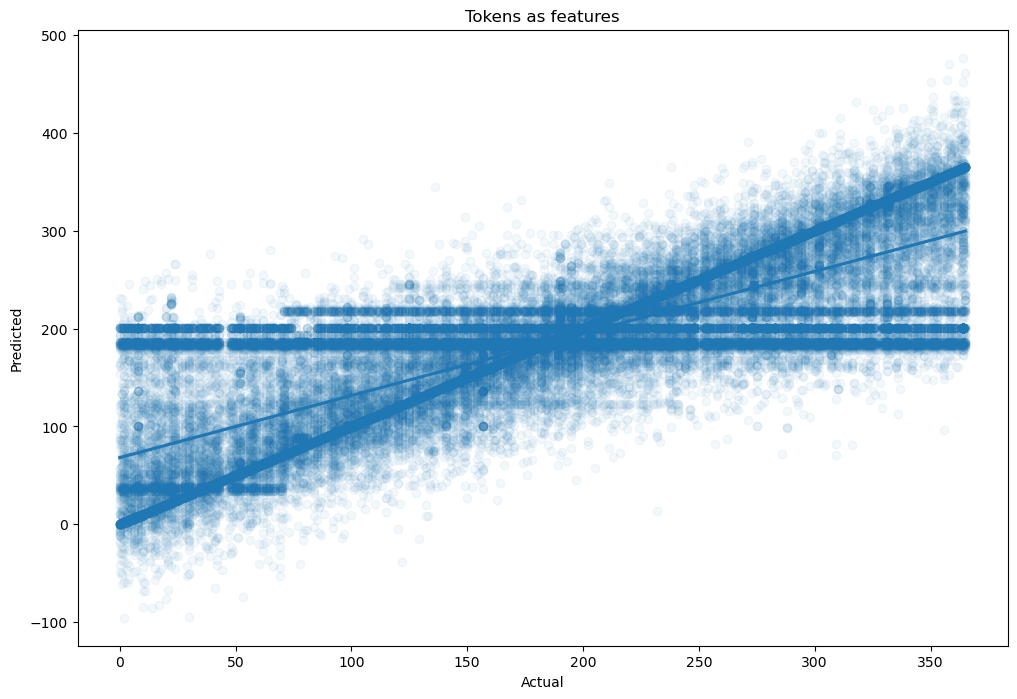

In [64]:
# Plot
fig,ax = plt.subplots(figsize=(12,8))
sns.regplot(x=date_integers, y=y_pred_date, scatter_kws={'alpha':0.05})
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Tokens as features")
plt.show()

___________________________________________________________

# Topic Based Models Using 200 Token Chunks as Features

#### Generating 200 token chunks

In [65]:
def generate_chunks(paragraphs, newsletter_types, dates, chunk_size=200):
    chunks = []
    chunk_newsletter_types = []
    chunk_dates = []

    for i in range(len(paragraphs)):
        text = paragraphs.iloc[i]  # Extract the text from the Series
        newsletter_type = newsletter_types.iloc[i]
        date = dates.iloc[i]

        # Split the text into paragraphs using '\n'
        text_paragraphs = text.split('\n')

        current_chunk = []
        current_chunk_newsletter_types = []

        for paragraph in text_paragraphs:
            # Check if the length of the paragraph exceeds the chunk size
            if len(paragraph) > chunk_size:
                chunks.append(paragraph)
                chunk_newsletter_types.append(newsletter_type)
                chunk_dates.append(date)
            else:
                # If not, add the paragraph to the current chunk
                current_chunk.append(paragraph)
                current_chunk_newsletter_types.append(newsletter_type)

                # Check if the current chunk size exceeds the specified limit
                if len(' '.join(current_chunk)) > chunk_size:
                    chunks.append(' '.join(current_chunk))
                    chunk_dates.extend([date])
                    chunk_newsletter_types.append(newsletter_type)
                    current_chunk = []
                    current_chunk_newsletter_types = []

        # Add any remaining paragraphs to the last chunk
        if current_chunk:
            chunks.append(' '.join(current_chunk))
            chunk_dates.extend([date])
            chunk_newsletter_types.append(newsletter_type)

    return chunks, chunk_newsletter_types, chunk_dates

# Generate chunks
result_chunks, newsletter_types_chunked, dates_chunked = generate_chunks(combined_datasets['paragraphs'], combined_datasets['newsletter'], combined_datasets['date'])

# Convert NYT and MB into binary representation
for i in range(len(newsletter_types_chunked)):
    if newsletter_types_chunked[i] == 'NYT':
        newsletter_types_chunked[i] = 1
    else:
        newsletter_types_chunked[i] = 0

In [66]:
# Convert date types into an integer representation
reference_date = datetime(2022, 10, 11)
date_integers_chunked = [(datetime.strptime(date_str, "%Y-%m-%d") - reference_date).days for date_str in dates_chunked]

In [67]:
X_chunked = vectorizer.fit_transform(result_chunks)

#### Topic Model Using 200 Token Chunks as Features

In [68]:
print_top_words(lda, vectorizer.get_feature_names_out(), n_top_words=10, hide_stops=False)

Topic  0: jan roll barbie visual hispanic warner pittsburgh fame pink hall
Topic  1: reserved rights all oil sellers best 2016 nonfiction alaska hardcover
Topic  2: bitcoin leadership tips living smarter for china moon nasa space
Topic  3: essentials programs business in 1980 excel hair shop hamlin skills
Topic  4: the to of in and that for is it on
Topic  5: written analytics by and killed gunman ohio train at people
Topic  6: paul prince column harry digit 2005 the pamela on goldberg
Topic  7: trump source the trial donald case charges his documents of
Topic  8: the in of to and num is for on it
Topic  9: dow york new times by the metropolitan diary museum opera
Topic 10: wirecutter melissa advice from kirsch clark by apple the dive
Topic 11: bps valley silicon st delivers insightful quick updates wall every
Topic 12: tournament france men march women alphabet open ben tennis finals
Topic 13: here wordle today mini crossword and sudoku clue letters july
Topic 14: search casual busine

### Baseline Logistic Regression Classification of Newsletter using Chunked Topic Features

In [69]:
chunk_doc_topic_matrix = lda.fit_transform(X_chunked)
print("Doc-topic matrix shape:", chunk_doc_topic_matrix.shape)

# Fit and predict using topics
X_topics_chunked = StandardScaler().fit_transform(chunk_doc_topic_matrix)

predictor = LogisticRegression()

predictor.fit(X_topics_chunked, newsletter_types_chunked)
y_pred = predictor.predict(X_topics_chunked)

# Cross-validation to evaluate the model
cv_accuracy = np.mean(cross_val_score(LogisticRegression(), X_topics_chunked, newsletter_types_chunked, scoring='accuracy', cv=10))
print("Mean cross-validated accuracy:", round(cv_accuracy, 3))

Doc-topic matrix shape: (25363, 50)
Mean cross-validated accuracy: 0.604


### Baseline Linear Regression Prediction of Publication Date Using Chunked Topic Features

In [70]:
len(X_topics_chunked), len(date_integers_chunked)

(25363, 25363)

In [71]:
predictor = LinearRegression()
predictor.fit(X_topics_chunked, date_integers_chunked)
y_pred = predictor.predict(X_topics_chunked)

# Cross-validation to evaluate the model
print("Mean cross-validated R^2 (topics):", round(np.mean(cross_val_score(LinearRegression(), X_topics_chunked, date_integers_chunked, scoring='r2', cv=10)),3))

Mean cross-validated R^2 (topics): -0.026


### Time Series of Topics using 200 Token Chunk Features

/Users/wally/anaconda3/envs/INFO4900/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/wally/anaconda3/envs/INFO4900/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


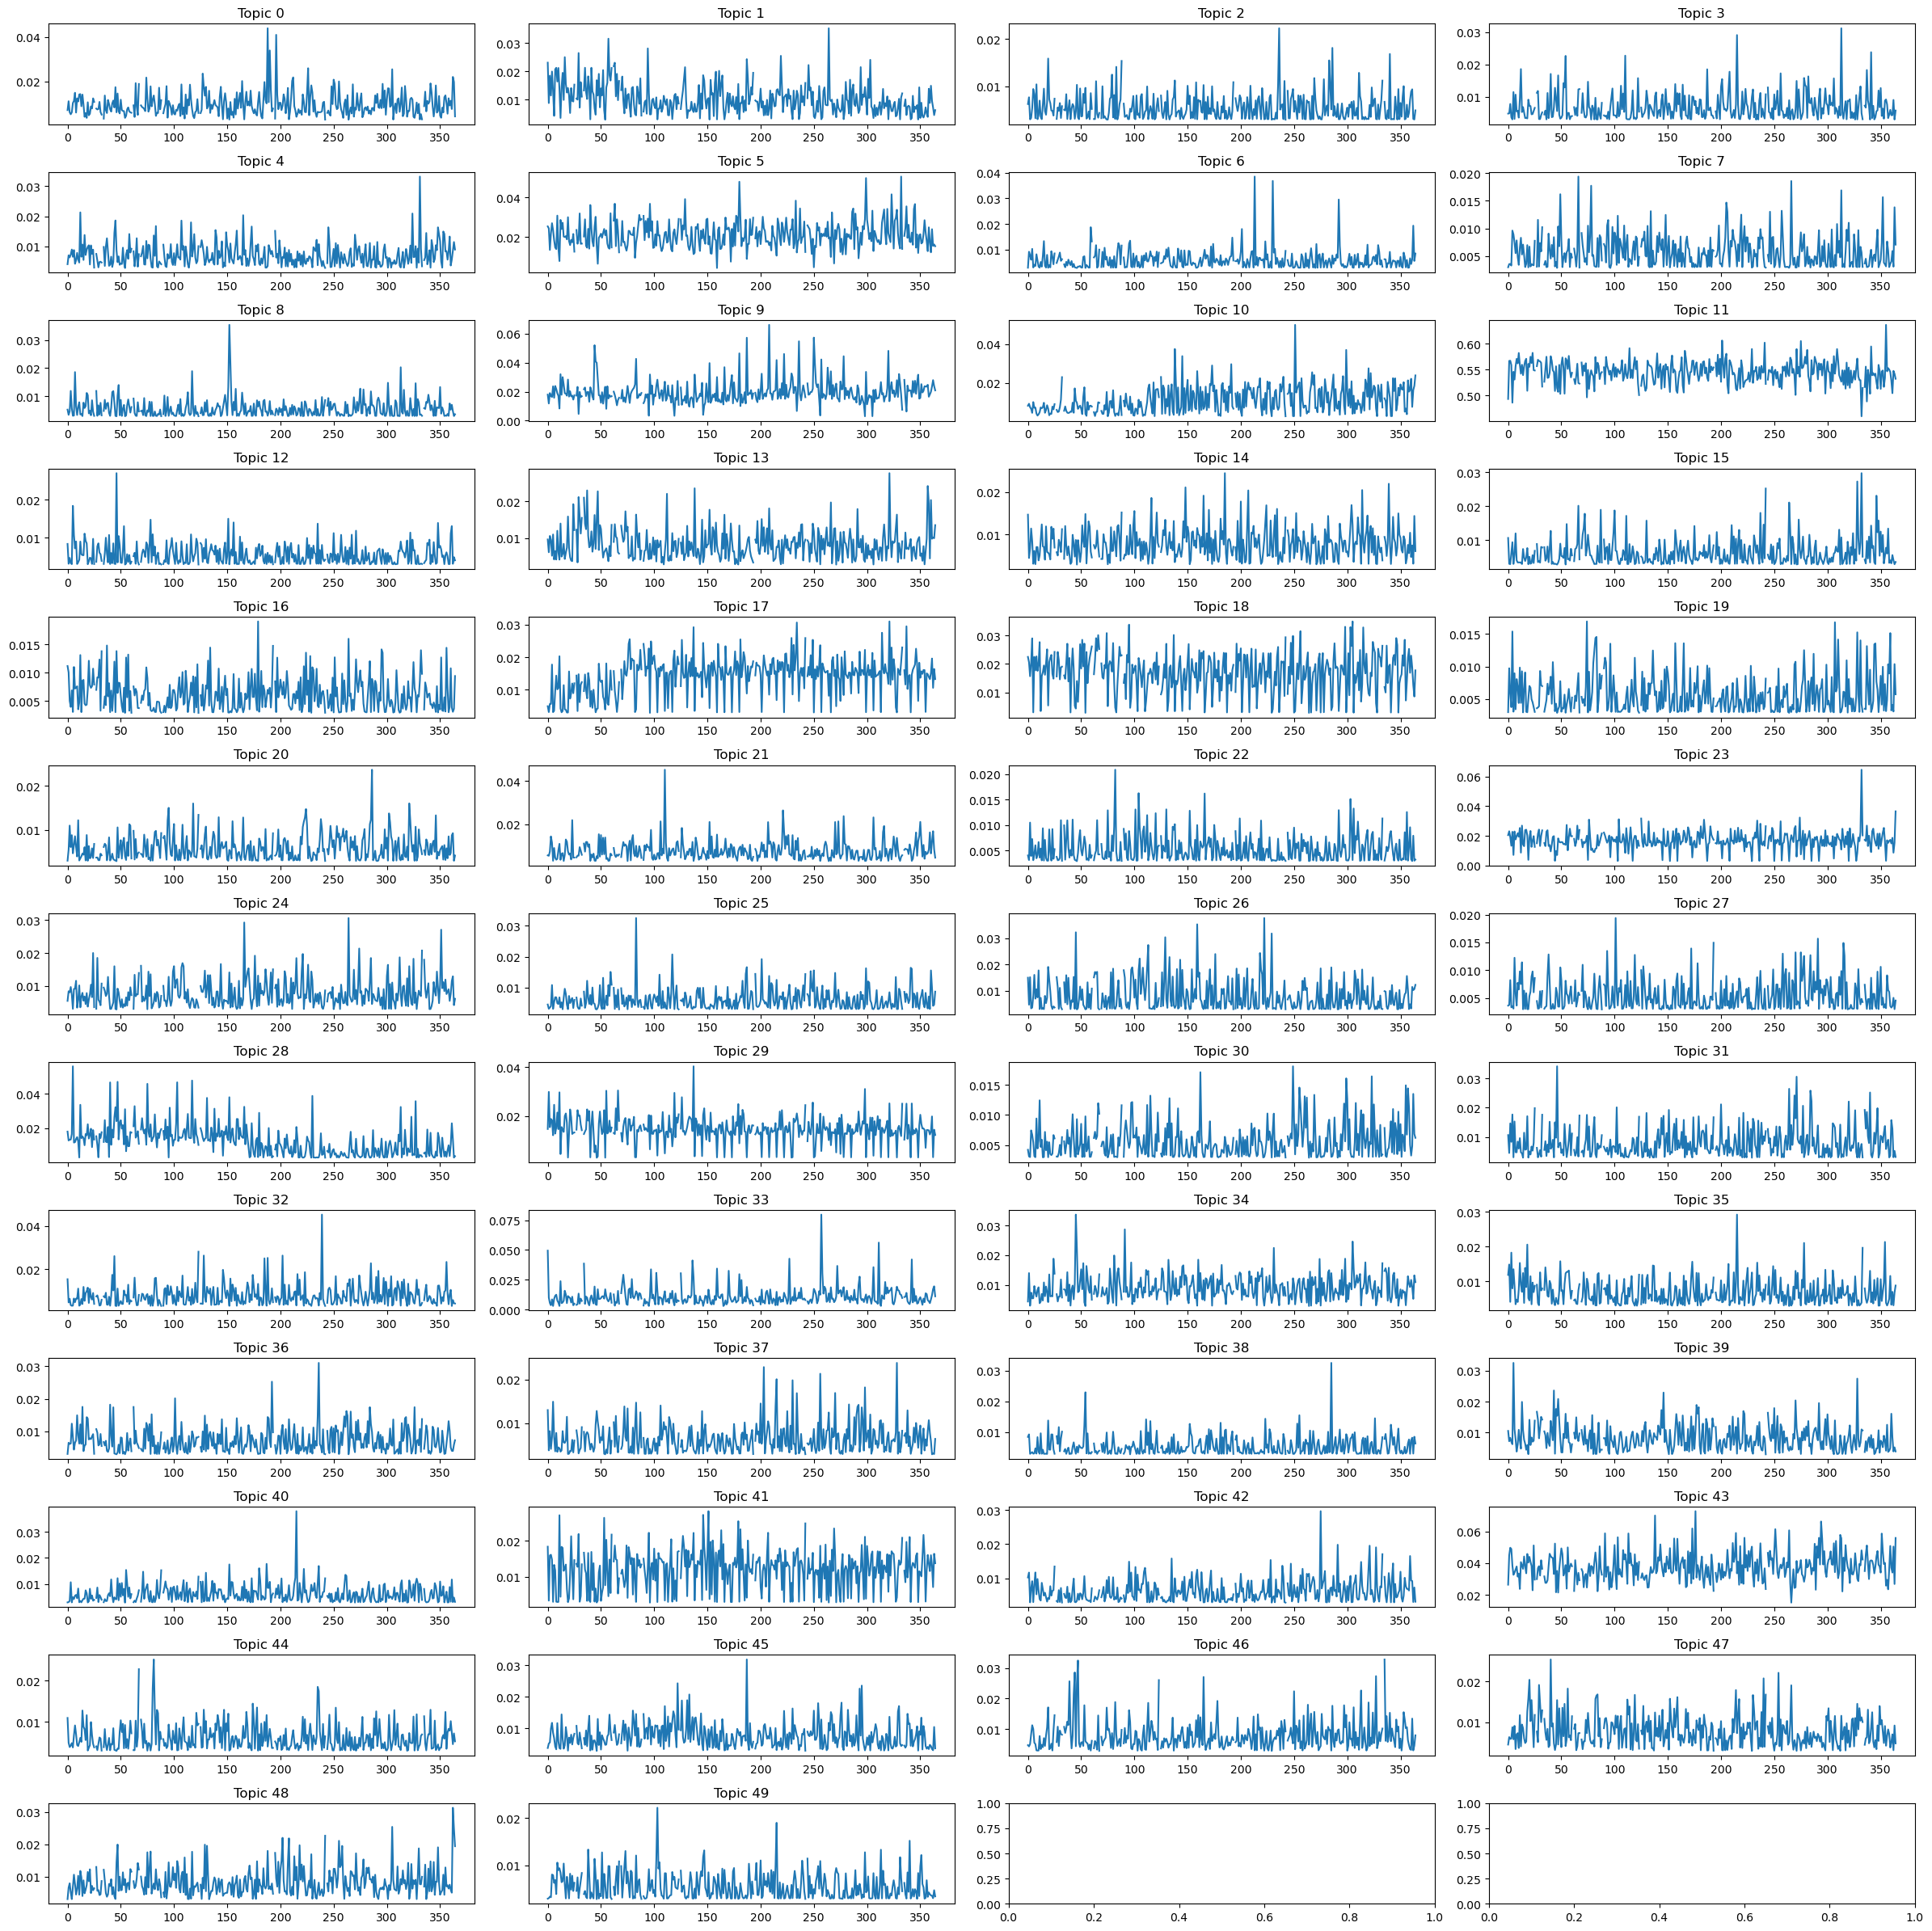

In [72]:
chunk_doc_topic_matrix = lda.fit_transform(X_chunked)

# Time series
n_cols = 4
n_topics = chunk_doc_topic_matrix.shape[1]
n_rows = n_topics/n_cols
if n_rows%1!=0:
    n_rows += 1
n_rows = int(n_rows)

fig, axs = plt.subplots(n_rows, n_cols, figsize=(24,24))
axs = axs.ravel()

valid_dates = list(range(max(date_integers_chunked)-min(date_integers_chunked)))
for topic in range(n_topics):
    topic_data = chunk_doc_topic_matrix[:,topic]
    topic_means = []
    for date in valid_dates:
        mask = np.equal(date_integers_chunked, date)
        topic_mean = np.mean(topic_data[mask])
        topic_means.append(topic_mean)
    axs[topic].plot(valid_dates, topic_means)
    axs[topic].set_title(f'Topic {topic}')
plt.tight_layout()
plt.show()

In [73]:
# Access the coefficients from the linear regression model
coefficients = predictor.coef_

# Display coefficients for each topic
for topic in range(n_topics):
    print(f'Topic {topic} Coefficients: {coefficients[topic]}')

Topic 0 Coefficients: -11974626067425.17
Topic 1 Coefficients: -13608222233435.672
Topic 2 Coefficients: -19502265550159.375
Topic 3 Coefficients: -8540484749565.848
Topic 4 Coefficients: -9772279197068.66
Topic 5 Coefficients: -10743849794144.309
Topic 6 Coefficients: -9958639484110.195
Topic 7 Coefficients: -36353582295188.55
Topic 8 Coefficients: -16562868482363.09
Topic 9 Coefficients: -10410658601328.43
Topic 10 Coefficients: -10540441203280.719
Topic 11 Coefficients: -12529706888538.7
Topic 12 Coefficients: -11705583100163.799
Topic 13 Coefficients: -9622729834131.979
Topic 14 Coefficients: -14406109093535.523
Topic 15 Coefficients: -14027617295076.564
Topic 16 Coefficients: -11844073030873.29
Topic 17 Coefficients: -7847295822961.541
Topic 18 Coefficients: -9844792827077.803
Topic 19 Coefficients: -11100401439408.912
Topic 20 Coefficients: -14008175569696.434
Topic 21 Coefficients: -42050097627436.14
Topic 22 Coefficients: -10221565264973.117
Topic 23 Coefficients: -855747376949

___________________________________________________________

# Token Based Models Using 200 Token Chunks as Features

### Baseline Logistic Regression Classification of Newsletter using Chunked Token Features

In [74]:
predictor = LogisticRegression(max_iter=100000000)
predictor.fit(X_chunked, newsletter_types_chunked)
y_pred = predictor.predict(X_chunked)

# Cross-validation to evaluate the model
cv_accuracy = np.mean(cross_val_score(LogisticRegression(), X_chunked, newsletter_types_chunked, scoring='accuracy', cv=10))
print("Mean cross-validated accuracy:", round(cv_accuracy, 3))

Mean cross-validated accuracy: 0.89


In [75]:
X_chunked.shape

(25363, 38726)

### Baseline Linear Regression Prediction of Publication Date using Chunked Token Features

In [76]:
predictor = LinearRegression()
predictor.fit(X_chunked, date_integers_chunked)
y_pred = predictor.predict(X_chunked)

# Cross-validation to evaluate the model
print("Mean cross-validated R^2 (topics):", round(np.mean(cross_val_score(LinearRegression(), X_chunked, date_integers_chunked, scoring='r2', cv=10)),3))

Mean cross-validated R^2 (topics): -26.607


In [77]:
# See non-cross validated comparison scores
mse = mean_squared_error(date_integers_chunked, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(date_integers_chunked, y_pred)
r2 = r2_score(date_integers_chunked, y_pred)

print(f'Mean Squared Error: {mse:.4f}')
print(f'Root Mean Squared Error: {rmse:.4f}')
print(f'Mean Absolute Error: {mae:.4f}')
print(f'R-squared Score: {r2:.4f}')

Mean Squared Error: 338.9283
Root Mean Squared Error: 18.4100
Mean Absolute Error: 3.6806
R-squared Score: 0.9695


#### Using a Reduced Feature Set (SelectKBest)

In [78]:
# Using 20 best word features

# Select best word features
method = f_regression
selector = SelectKBest(method, k=20)
X_words = selector.fit_transform(X_chunked, date_integers_chunked)

# Score
print("Mean cross-validated R^2 (words):", round(np.mean(cross_val_score(LinearRegression(), X_words, date_integers_chunked, scoring='r2', cv=10)),3))

Mean cross-validated R^2 (words): 0.02


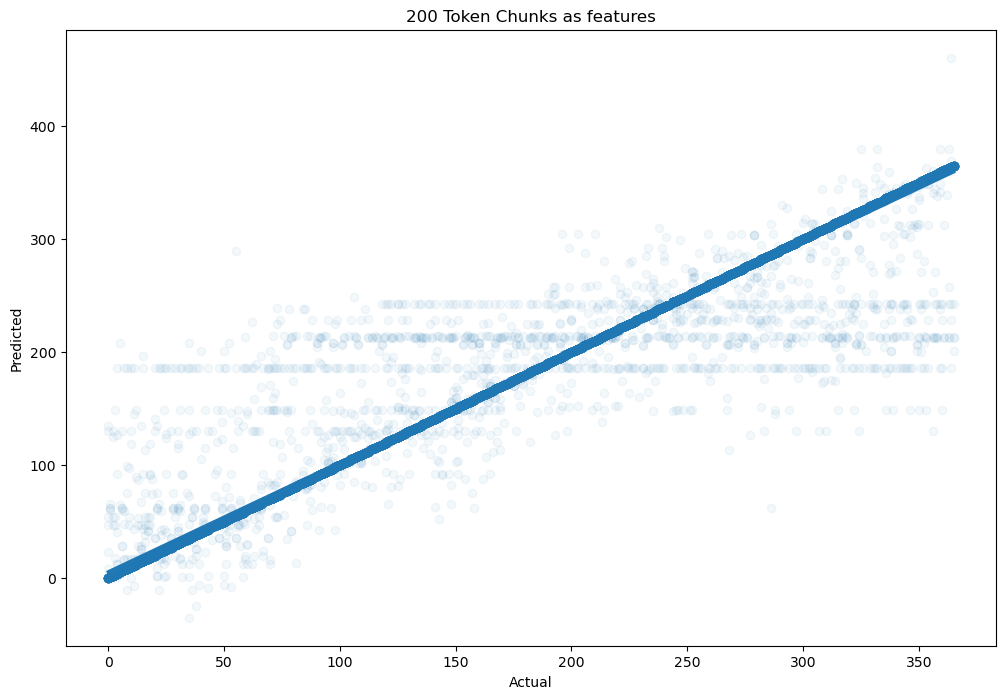

In [79]:
# Plot with regression line
fig, ax = plt.subplots(figsize=(12, 8))
sns.regplot(x=date_integers_chunked, y=y_pred, scatter_kws={'alpha': 0.05}, ci=None)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("200 Token Chunks as features")
plt.show()

_____________________________________________________

# 200 Chunk Token Based Regression Prediction of Month

#### Reuse generate_chunks code with month input instead of dates

In [80]:
def generate_chunks(paragraphs, newsletter_types, dates, chunk_size=500):
    chunks = []
    chunk_newsletter_types = []
    chunk_dates = []

    for i in range(len(paragraphs)):
        text = paragraphs.iloc[i]  # Extract the text from the Series
        newsletter_type = newsletter_types.iloc[i]
        date = dates.iloc[i]

        # Split the text into paragraphs using '\n'
        text_paragraphs = text.split('\n')

        current_chunk = []
        current_chunk_newsletter_types = []

        for paragraph in text_paragraphs:
            # Check if the length of the paragraph exceeds the chunk size
            if len(paragraph) > chunk_size:
                chunks.append(paragraph)
                chunk_newsletter_types.append(newsletter_type)
                chunk_dates.append(date)
            else:
                # If not, add the paragraph to the current chunk
                current_chunk.append(paragraph)
                current_chunk_newsletter_types.append(newsletter_type)

                # Check if the current chunk size exceeds the specified limit
                if len(' '.join(current_chunk)) > chunk_size:
                    chunks.append(' '.join(current_chunk))
                    chunk_dates.extend([date])
                    chunk_newsletter_types.append(newsletter_type)
                    current_chunk = []
                    current_chunk_newsletter_types = []

        # Add any remaining paragraphs to the last chunk
        if current_chunk:
            chunks.append(' '.join(current_chunk))
            chunk_dates.extend([date])
            chunk_newsletter_types.append(newsletter_type)

    return chunks, chunk_newsletter_types, chunk_dates

# Generate chunks
result_chunks, dates_chunked, months_chunked = generate_chunks(combined_datasets['paragraphs'], combined_datasets['date'], combined_datasets['month'])

In [81]:
X_chunked = vectorizer.fit_transform(result_chunks)

In [82]:
predictor = LinearRegression()
predictor.fit(X_chunked, months_chunked)
y_pred = predictor.predict(X_chunked)

# Cross-validation to evaluate the model
print("Mean cross-validated R^2 (topics):", round(np.mean(cross_val_score(LinearRegression(), X_chunked, months_chunked, scoring='r2', cv=10)),3))

Mean cross-validated R^2 (topics): -1.398


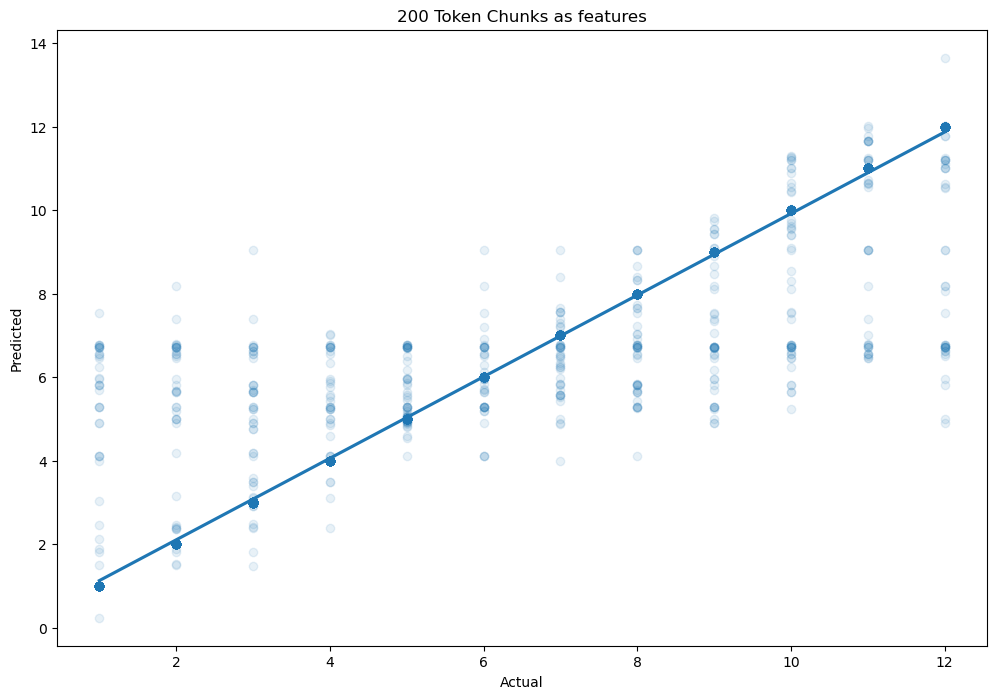

In [83]:
# Plot with regression line
fig, ax = plt.subplots(figsize=(12, 8))
sns.regplot(x=months_chunked, y=y_pred, scatter_kws={'alpha': 0.1}, ci=None)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("200 Token Chunks as features")
plt.show()

In [84]:
vectorizer = TfidfVectorizer(use_idf=True, norm=None)
X_chunked = vectorizer.fit_transform(result_chunks)

In [85]:
features = pd.DataFrame(X_chunked.toarray(), columns=vectorizer.get_feature_names_out())

In [86]:
# Create and fit the linear regression model
predictor = LinearRegression()
predictor.fit(X_chunked, months_chunked)

# Access the coefficients from the linear regression model
coefficients = predictor.coef_

# Create a DataFrame to display features and coefficients
result_df = pd.DataFrame({'Feature': features.columns, 'Coefficient': coefficients})

# Sort the DataFrame by coefficient magnitude
result_df = result_df.reindex(result_df['Coefficient'].abs().sort_values(ascending=False).index)

# Print the top 20 most informative features for the entire model
print("Top 20 Most Informative Features for All Months:")
print(result_df.head(20))

Top 20 Most Informative Features for All Months:
               Feature  Coefficient
20318           london    -2.267494
38277           writer     1.854787
25801            pills    -1.538064
20588              lvi    -1.518143
645           abortion     1.297542
23097        nashville     1.291549
4802        broadcasts    -1.055912
25794             pill    -1.050358
28522           relist     1.030051
25339          pegging     1.030051
15938        heightens     1.030051
31278            shuns     1.030051
4401               bot     0.958795
34704             this     0.952503
9727          devoting    -0.946580
22606            moses    -0.927716
23380         newsroom    -0.889347
23637  nonrambunctious    -0.883428
10649            draft     0.874536
32532         sportico    -0.873957


In [87]:
# List of most informative features
selected_features = ['lvi', 'london', 'pills', 'broadcasts', 'writer', 'sportico', 'devoting', 'abortion', 'nashville', 'newsroom', 'this', 'nielsen', 'bot', 'pill', 'nonrambunctious', 'winter', 'draft', 'moses', 'pegging', 'relist']

# Filter the features based on the selected features
selected_feature_matrix = features[selected_features]

# Create and fit the linear regression model
predictor = LinearRegression()
predictor.fit(selected_feature_matrix, months_chunked)

# Access the coefficients from the linear regression model
coefficients = predictor.coef_

# Create a DataFrame to display features and coefficients
result_df = pd.DataFrame({'Feature': selected_features, 'Coefficient': coefficients})

# Sort the DataFrame by coefficient magnitude
result_df = result_df.reindex(result_df['Coefficient'].abs().sort_values(ascending=False).index)

# Predict values using the selected features
y_pred_selected_features = predictor.predict(selected_feature_matrix)

# Display the predicted values for each observation using the selected features
predicted_values_selected_features_df = pd.DataFrame({'Predicted_Value': y_pred_selected_features}, index=features.index)
combined_df = pd.merge(result_df, predicted_values_selected_features_df, left_index=True, right_index=True)

# Print the combined DataFrame
print("\nCombined DataFrame:")
print(combined_df)


Combined DataFrame:
            Feature   Coefficient  Predicted_Value
18          pegging -1.386863e+13         6.298603
19           relist  1.386863e+13         6.542898
5          sportico -3.993068e-01         6.515594
14  nonrambunctious -3.375513e-01         8.115440
0               lvi -3.061372e-01         6.955588
12              bot  2.674184e-01         6.542898
3        broadcasts  1.817614e-01         6.515594
16            draft -1.526122e-01         6.515594
2             pills -1.470380e-01         6.762895
17            moses -1.360667e-01         6.884518
13             pill -1.211410e-01         6.570202
8         nashville -8.191928e-02         6.515594
9          newsroom -6.622121e-02         6.515594
1            london  6.537748e-02         6.542898
6          devoting -5.920290e-02         6.735591
4            writer -4.699378e-02         6.515594
7          abortion  4.655960e-02         6.515594
11          nielsen -4.048907e-02         6.515594
15        

________________________________________________________

# Application of BERT for a Supervised Regression Task
reference: https://medium.com/ilb-labs-publications/fine-tuning-bert-for-a-regression-task-is-a-description-enough-to-predict-a-propertys-list-price-cf97cd7cb98a

In [ ]:
from transformers import DistilBertTokenizerFast
import torch
from torch.utils.data import TensorDataset, DataLoader
from transformers import BertModel
import torch.nn as nn
from transformers import AdamW
from transformers import get_linear_schedule_with_warmup
from torch.nn.utils.clip_grad import clip_grad_norm_
from transformers import Trainer, TrainingArguments

In [ ]:
model_name = 'distilbert-base-cased'

# Create tokenizer
tokenizer = DistilBertTokenizerFast.from_pretrained(model_name)

In [134]:
type(result_chunks)

list

In [ ]:
# Create tokenizer
encoded_corpus = tokenizer(text=result_chunks,
                            add_special_tokens=True,
                            padding='max_length',
                            truncation='longest_first',
                            max_length=300,
                            return_attention_mask=True)

input_ids = encoded_corpus['input_ids']
attention_mask = encoded_corpus['attention_mask']

In [ ]:
test_size = 0.1
validation_size = 0.2
seed = 42
labels = date_integers_chunked

# Initial split into training/testing sets
train_inputs, test_inputs, train_labels, test_labels = train_test_split(input_ids, labels, test_size=test_size, random_state=seed)
train_masks, test_masks, _, _ = train_test_split(attention_mask, labels, test_size=test_size, random_state=seed)

# Further split the testing set into testing and validation sets
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(train_inputs, train_labels, test_size=validation_size, random_state=seed)
train_masks, validation_masks, _, _ = train_test_split(train_masks, train_masks, test_size=validation_size, random_state=seed)

# Convert labels to NumPy arrays
train_labels = np.array(train_labels)
test_labels = np.array(test_labels)
validation_labels = np.array(validation_labels)


In [ ]:
date_scaler = StandardScaler()
date_scaler.fit(train_labels.reshape(-1, 1))

train_labels = date_scaler.transform(train_labels.reshape(-1, 1))
test_labels = date_scaler.transform(test_labels.reshape(-1, 1))

In [ ]:
batch_size = 32

def create_dataloaders(inputs, masks, labels, batch_size):
    input_tensor = torch.tensor(inputs, dtype=torch.float32)
    mask_tensor = torch.tensor(masks, dtype=torch.float32)
    labels_tensor = torch.tensor(labels, dtype=torch.float32)

    # input_tensor = torch.tensor(inputs)
    # mask_tensor = torch.tensor(masks)
    # labels_tensor = torch.tensor(labels)
    # print(labels_tensor.dtype)

    dataset = TensorDataset(input_tensor, mask_tensor,
                            labels_tensor)
    dataloader = DataLoader(dataset, batch_size=batch_size,
                            shuffle=True)
    return dataloader

train_dataloader = create_dataloaders(train_inputs, train_masks, train_labels, batch_size)
test_dataloader = create_dataloaders(test_inputs, test_masks, test_labels, batch_size)

In [ ]:
class BertRegressor(nn.Module):

    def __init__(self, drop_rate=0.2):

        super(BertRegressor, self).__init__()
        D_in, D_out = 768, 1  # Assuming you want a single regression output

        self.bert = \
            BertModel.from_pretrained('bert-base-uncased')

        self.regressor = nn.Sequential(
            nn.Dropout(drop_rate),
            nn.Linear(D_in, D_out))

    def forward(self, input_ids, attention_masks):

        outputs = self.bert(input_ids=input_ids, attention_mask=attention_masks)
        pooled_output = outputs['pooler_output']
        outputs = self.regressor(pooled_output)
        return outputs

# Create an instance of the model
model = BertRegressor(drop_rate=0.2)


In [ ]:
device = torch.device('cuda')

model.to(device)

In [ ]:
# # Save fine-tuned model

# local_path = '/content/drive/MyDrive/Fourth Year/newsletter sentiment analysis'
# trainer.save_model(local_path)

In [ ]:
# Adam optimizer
optimizer = AdamW(model.parameters(),
                  lr=5e-5,
                  eps=1e-8)

In [ ]:
epochs = 5
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer,
                 num_warmup_steps=0, num_training_steps=total_steps)

In [ ]:
loss_function = nn.MSELoss()

In [ ]:
len(train_dataloader)

In [125]:
load_path = '/content/drive/MyDrive/Fourth Year/newsletter sentiment analysis/model_after_training.pth'
model.load_state_dict(torch.load(load_path))

<All keys matched successfully>

In [122]:
def train(model, optimizer, scheduler, loss_function, epochs,
          train_dataloader, device, clip_value=2):
    for epoch in range(epochs):
        print(epoch)
        print("-----")
        best_loss = 1e10
        model.train()
        for step, batch in enumerate(train_dataloader):
            batch_inputs, batch_masks, batch_labels = tuple(b.to(device) for b in batch)

            batch_inputs = batch_inputs.to(torch.long)  # Convert input_ids to torch.long

            model.zero_grad()
            outputs = model(batch_inputs, batch_masks)
            loss = loss_function(outputs.squeeze(),
                             batch_labels.squeeze())
            loss.backward()
            clip_grad_norm_(model.parameters(), clip_value)
            optimizer.step()
            scheduler.step()

    return model

model = train(model, optimizer, scheduler, loss_function, epochs, train_dataloader, device, clip_value=2)

0
-----
1
-----
2
-----
3
-----
4
-----


In [124]:
# Save path
save_path = '/content/drive/MyDrive/Fourth Year/newsletter sentiment analysis/model_after_training.pth'

# Save the trained model
torch.save(model.state_dict(), save_path)

In [130]:
def evaluate(model, loss_function, test_dataloader, device):
    model.eval()
    test_loss, test_r2 = [], []
    for batch in test_dataloader:
        batch_inputs, batch_masks, batch_labels = tuple(b.to(device) for b in batch)

        batch_inputs = batch_inputs.to(torch.long)  # Convert input_ids to torch.long

        with torch.no_grad():
            outputs = model(batch_inputs, batch_masks)
        loss = loss_function(outputs, batch_labels)
        test_loss.append(loss.item())
        r2 = r2_score(outputs, batch_labels)
        test_r2.append(r2.item())
    return test_loss, test_r2

def r2_score(outputs, labels):
    labels_mean = torch.mean(labels)
    ss_tot = torch.sum((labels - labels_mean) ** 2)
    ss_res = torch.sum((labels - outputs) ** 2)
    r2 = 1 - ss_res / ss_tot
    return r2

ValueError: ignored

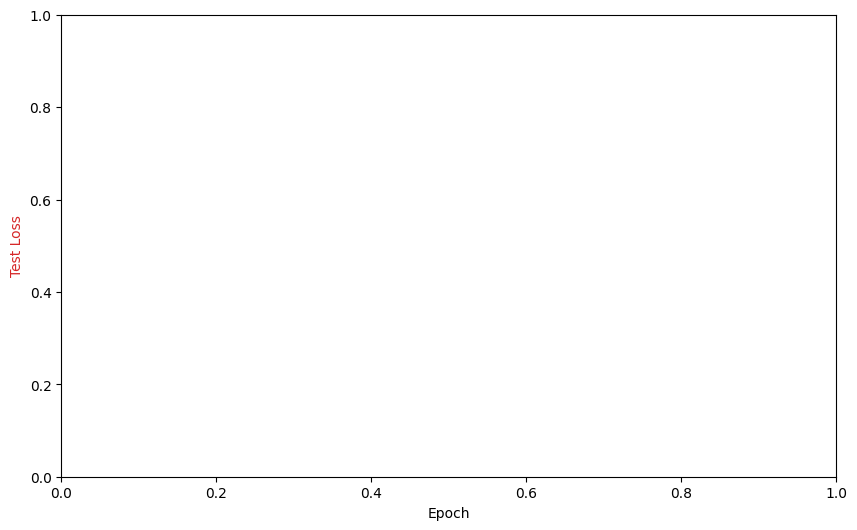

In [136]:

def plot_metrics(test_losses, test_r2_scores):
    epochs = range(1, len(test_losses) + 1)

    # Plot Loss and R2 score per epoch
    fig, ax1 = plt.subplots(figsize=(10, 6))

    color = 'tab:red'
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Test Loss', color=color)
    ax1.plot(epochs, test_losses, label='Train Loss', marker='o', color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.legend(loc='upper left')

    ax2 = ax1.twinx()
    color = 'tab:blue'
    ax2.set_ylabel('R2 Score', color=color)
    ax2.plot(epochs, test_r2_scores, label='Test Loss', marker='o', color=color)
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.legend(loc='upper right')

    fig.tight_layout()
    plt.title('Train Loss and Test Loss per epoch')
    plt.show()

# Example usage
train_losses, test_losses = evaluate(model, loss_function, test_dataloader, device)
plot_metrics(train_losses, test_losses)
